In [1]:
import os
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt

In [2]:
######CAMERA CALIBERATION########
import numpy as np
import cv2
import pickle

def CameraCaliberation():
    calliberation_val=[]
    cam_cal_imgs = os.listdir("./camera_cal/")
    caliberationimgs=[]
    for i in cam_cal_imgs:
        img = mpimg.imread("./camera_cal/"+i)
        caliberationimgs.append(img)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    for i in caliberationimgs:
        gray = cv2.cvtColor(i, cv2.COLOR_RGB2GRAY)
        ret,corners = cv2.findChessboardCorners(gray, (9,6), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    img_size=(caliberationimgs[0].shape[1],caliberationimgs[0].shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    calliberation_val.append(ret)
    calliberation_val.append(mtx)
    calliberation_val.append(dist)
    return calliberation_val
#     plt.figure(figsize=(20,20))
#     for i in caliberationimgs:
#         plt.subplot(10,5,counter)
#         plt.imshow(i)
#         plt.axis('off')
#         counter+=1
#     plt.show()

In [3]:
####UNDISTORT IMAGES#######

def Undistort(img):
#     cam_caliberation_values = CameraCaliberation() # call Camera Calliberation function to calliberate the camera
    undistort_imgs =[]
    ret = cam_caliberation_values[0]
    mtx = cam_caliberation_values[1]
    dist = cam_caliberation_values[2]
    dst = cv2.undistort(img, mtx, dist, None, mtx)
#             undistort_imgs.append(dst)
    return dst # retun the undistorted image
# counter = 1
# plt.figure(figsize=(30,30))
# print("Undistorted Images")
# for i in undistort_imgs:
#     plt.subplot(4,2,counter)
#     plt.imshow(i)
#     counter+=1
# plt.show()


In [4]:
#####PERSPECTIVE TRANSFORM########
def PerspectiveTransform(img):
    
    width = img.shape[1]
    height = img.shape[0]
    src = np.float32([(600,450),
                         (700,450),
                         (280,710),
                         (1080,710)])
    dst = np.float32([(250,0),
                         (width-390,0),
                         (250,height),
                         (width-390,height)])

    M = cv2.getPerspectiveTransform(src, dst)
    minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
#     warped_imgs = []
#     for undistImg in undistort_imgs:
#         warped = cv2.warpPerspective(undistImg, M, img_size)
#         warped_imgs.append(warped)
    
    warped_img = cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]))
    
    return warped_img,minv
    
# counter = 1
# plt.figure(figsize=(30,30))
# print("Warped Images")
# for i in warped_imgs:
#     plt.subplot(4,2,counter)
#     plt.imshow(i)
#     counter+=1
# plt.show()

In [5]:
#######IMAGE PREPROCESSING######
#convert to HLS 
#extract S channel image and convert to binary
#convert to gray scale
#apply sobel
#apply gradient threshold
#combine gradient and threshold
def ColorThresholding(img):    
#     color_channelimgs=[]
#     for img in warped_imgs:
    #R CHANNEL
    r_channel = img[:,:,0]
    r_thresh = (220, 255)
    binary_rchannel = np.zeros_like(r_channel)
    binary_rchannel[(r_channel > r_thresh[0]) & (r_channel <= r_thresh[1])] = 1

    im_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #S CHANNEL
    s_channel = im_hls[:,:,2]
    s_thresh = (160, 255)
    binary_schannel = np.zeros_like(s_channel)
    binary_schannel[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    #HUE CHANNEL
    h_channel = im_hls[:,:,0]
    h_thresh =(45,58)
    binary_hchannel = np.zeros_like(h_channel)
    binary_hchannel[(h_channel > h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    
    #L CHANNEL
    l_channel = im_hls[:,:,1]
    l_thresh = (90, 100)
    binary_lchannel = np.zeros_like(l_channel)
    binary_lchannel[(l_channel > l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    #Combining All Channels
    binary_combined= np.zeros_like(s_channel)
    binary_combined[(binary_schannel==1) | (binary_rchannel ==1) | ((binary_hchannel==1)&(binary_lchannel==1))]=1
    final_output = np.zeros_like(s_channel)
    return binary_combined # return the combined result of all channels

#     color_channelimgs.append(binar_combined)
# print("S and R Channel output Images")
# plt.figure(figsize=(10,10))
# counter=1
# for i in color_channelimgs:
#     plt.subplot(4,2,counter)
#     plt.imshow(i, cmap="gray")
#     plt.axis("off")
#     counter+=1

# plt.show()

In [6]:
#Applying Sobel and Gradient Threshold
def GradThresholding(img):
    
#     gradthresh_imgs =[]
#     for img in warped_imgs:
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kernel_size = 5
    sobel_thresh = (20,100)
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size), 0)
    abs_sobelx = np.absolute(cv2.Sobel(blur_gray, cv2.CV_64F, 1, 0))
    abs_sobely = np.absolute(cv2.Sobel(blur_gray, cv2.CV_64F, 0, 1))
    grad_magnitude = np.sqrt(abs_sobelx**2 + abs_sobely**2)
    scaled_gradient = np.uint8(255*grad_magnitude/np.max(grad_magnitude))
    binary_gradient = np.zeros_like(scaled_gradient)
    binary_gradient[(scaled_gradient >= sobel_thresh[0]) & (scaled_gradient <= sobel_thresh[1])] = 1
    return binary_gradient
#     gradthresh_imgs.append(binary_gradient)
    

# plt.figure(figsize=(10,10))
# counter=1
# for i,j in zip(warped_imgs,gradthresh_imgs):
#     plt.subplot(8,2,counter+1)
#     plt.imshow(i, cmap="gray")
#     plt.axis("off")
#     plt.title("Warped Image")
#     plt.subplot(8,2,counter)
#     plt.imshow(j, cmap="gray")    
#     plt.axis("off")
#     plt.title("Gradient Threshold Image")   
#     counter+=2

# plt.show()

In [7]:
def CombineThersholds(color_binaryThresh, gradientThesh,img):
    r_channel = img[:,:,0]
    final_output = np.zeros_like(r_channel)
    final_output[(color_binaryThresh == 1) | (gradientThesh == 1)] = 1
    return final_output


In [8]:
#####SLIDING WINDOW######
import numpy as np
import cv2
import matplotlib.pyplot as plt
# histogram,combined_grad_color,Minv,dst,image
def SlidingWindow(histogram,binary_warped,Minv,undistImg,image):
    
#     histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)



    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    ##unwarping and replotting the image on the original image 
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
#     Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    return result

In [9]:
def PipelineForVideo(image):
    dst = Undistort(image)
    prespect_transformed_img,Minv = PerspectiveTransform(dst)
    color_threshold = ColorThresholding(prespect_transformed_img)
    grad_threshold = GradThresholding(prespect_transformed_img)   
    combined_grad_color = CombineThersholds(color_threshold,grad_threshold,prespect_transformed_img)
    histogram = np.sum(combined_grad_color[combined_grad_color.shape[0]//2:,:], axis=0)
    result = SlidingWindow(histogram,combined_grad_color,Minv,dst,image)
    return result

[MoviePy] >>>> Building video ./test_video_output/project_video_output.mp4
[MoviePy] Writing video ./test_video_output/project_video_output.mp4


100%|█████████▉| 1260/1261 [02:52<00:00,  7.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_video_output/project_video_output.mp4 

CPU times: user 6min 15s, sys: 12.8 s, total: 6min 28s
Wall time: 2min 53s


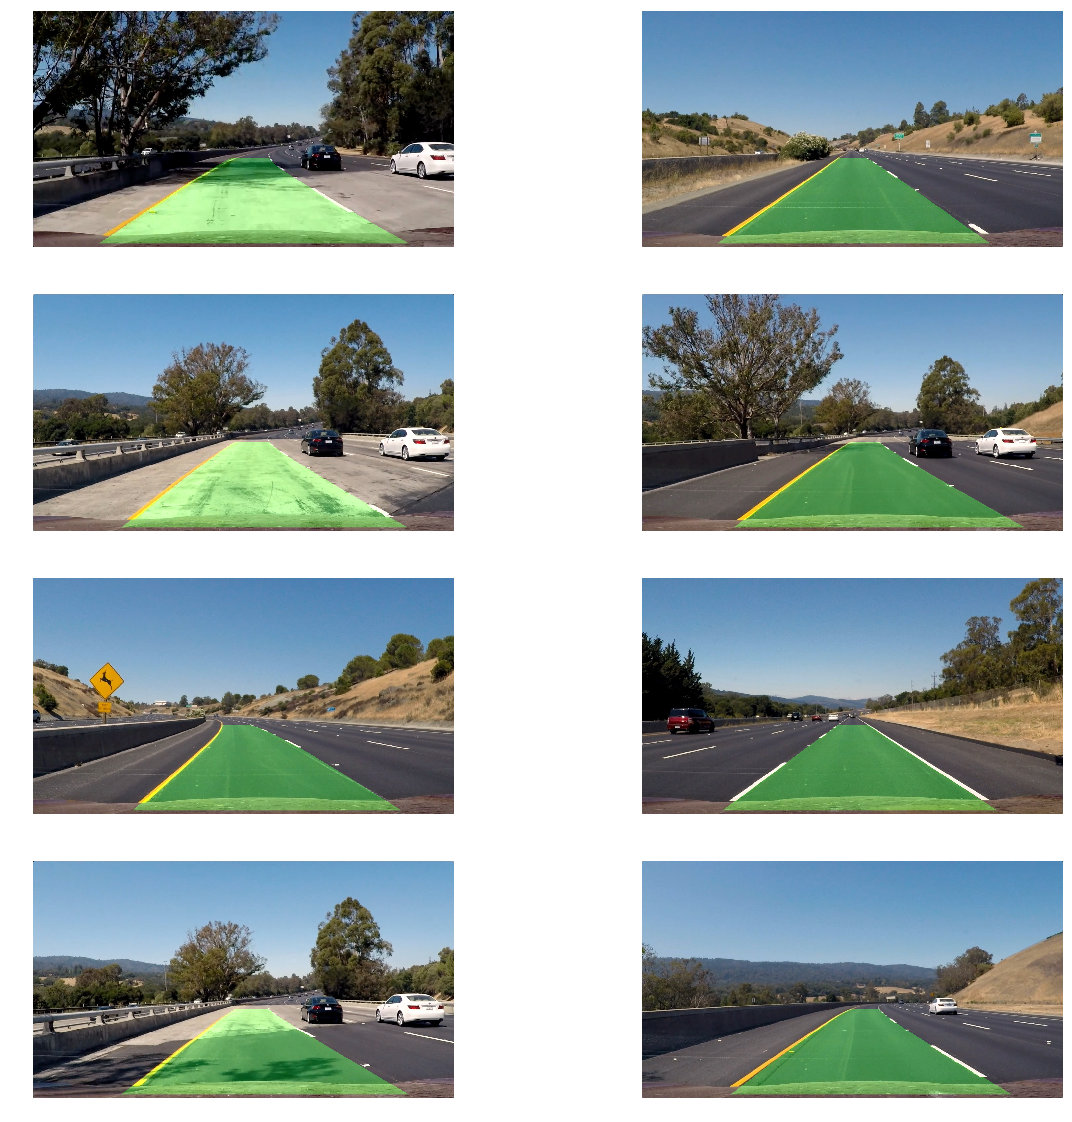

In [12]:
from moviepy.editor import VideoFileClip
global cam_caliberation_values
cam_caliberation_values =[]
if os.path.isdir("test_video_output"):
    pass
else:
    os.mkdir("test_video_output")
white_output = "./test_video_output/project_video_output.mp4"
clip1 = VideoFileClip("./project_video.mp4")   
cam_caliberation_values = CameraCaliberation()
white_clip = clip1.fl_image(PipelineForVideo) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
# clip1.reader.close()


#For Test Images:
test_imgs = os.listdir("./test_images/")
images=[]
for i in test_imgs:
    img = mpimg.imread("./test_images/"+i)
    images.append(img)
plt.figure(figsize=(20,20))
counter = 1
res_imgs = []
for img in images:
    result = PipelineForVideo(img)
    res_imgs.append(result)

for i in res_imgs:
    plt.subplot(4,2,counter)
    plt.imshow(i)
    plt.axis("off")
    counter += 1
plt.show()    